# **Kickstart Data**

## Within the project various range of topics were covered:

*   Outliers treatment
*   Missing values treatment
*   Data transformation (normalization, one hot encoding, feature transformation, undersampling)
*   Other parts of EDA (assessment of distribution, correlation, NUMEROUS data aggregation operations for local tasks during the project)
*   NLP
*   Clustering
*   Modeling and evaluation

## The order of task conduction is summarized below:

*   First look into data
*   Consequent research of data features (immediate treatment, filtering and transformation)
*   Latent Dirichle Algorithm (LDA) for topic detection
*   Brief clustering stage
*   Data preparation (undersampling) - finalisng the data appearance in both dimensions
*   Modeling and evaluation stage






In [109]:
 !pip install stop_words

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import gensim
from scipy.interpolate import splrep, UnivariateSpline
from scipy.stats import kendalltau, spearmanr, pearsonr
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **First look at the data**

Importing initial data from Kaggle, where it was divided into train, test and test target values samples. The structure is typical for Kaggle Competitions (not my case)

In [111]:
initial_train_data = pd.read_csv('/content/drive/My Drive/train.csv')
initial_test_data = pd.read_csv('/content/drive/My Drive/test.csv')
initial_samplesubmission_data = pd.read_csv('/content/drive/My Drive/samplesubmission.csv')

for data in [initial_train_data, initial_test_data, initial_samplesubmission_data]:
    data.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108129 entries, 0 to 108128
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   project_id             108129 non-null  object 
 1   name                   108126 non-null  object 
 2   desc                   108120 non-null  object 
 3   goal                   108129 non-null  float64
 4   keywords               108129 non-null  object 
 5   disable_communication  108129 non-null  bool   
 6   country                108129 non-null  object 
 7   currency               108129 non-null  object 
 8   deadline               108129 non-null  int64  
 9   state_changed_at       108129 non-null  int64  
 10  created_at             108129 non-null  int64  
 11  launched_at            108129 non-null  int64  
 12  backers_count          108129 non-null  int64  
 13  final_status           108129 non-null  int64  
dtypes: bool(1), float64(1), int64(6), ob

In the text data there were no backers count column. Even though it cannot be used for modeling and evaluation part as it would be cheating, I would be beneficial to have it during EDA + the 100,000 rows in train sample is more than enough. We schould just check whether it is not empty:

In [112]:
print(initial_train_data["backers_count"].isna().sum())
initial_train_data["backers_count"].describe()

0


count   108129.00
mean       123.52
std       1176.75
min          0.00
25%          2.00
50%         17.00
75%         65.00
max     219382.00
Name: backers_count, dtype: float64

Let's stick with train data, without merging with test, since no missing values are there



A bit more for the first look at the data:

In [113]:
kickdata = initial_train_data
print('head of keywords column')
print('\n')
print(kickdata['keywords'].head()) # we observe that keywords column is decent
print('\n')

# checking duplicates (there are no duplicated rows)

counting_duplicates = kickdata.groupby("project_id").size()
print(f'number of mduplicates: {len(counting_duplicates[counting_duplicates>1])}')
print('\n')


# checking missing values that appear in a few rows, with the data type string, while

print('missing values')
print('\n')
print(kickdata.isna().sum(axis = 0))
print('\n')


# for roww with missing texts or decriptions there are still keywords, which are more useful anyway


print('keywords for missing value ')
print('\n')
list_of_indexes = kickdata.isna().query('name == True or desc == True').index
kickdata.loc[list(list_of_indexes),"keywords"] # shows another text attribute for the rows with missing names or descriptions


head of keywords column


0                                  drawing-for-dollars
1    sponsor-dereck-blackburn-lostwars-artist-in-re...
2                                         mr-squiggles
3                        help-me-write-my-second-novel
4               support-casting-my-sculpture-in-bronze
Name: keywords, dtype: object


number of mduplicates: 0


missing values


project_id               0
name                     3
desc                     9
goal                     0
keywords                 0
disable_communication    0
country                  0
currency                 0
deadline                 0
state_changed_at         0
created_at               0
launched_at              0
backers_count            0
final_status             0
dtype: int64


keywords for missing value 




13244        you-have-the-power-to-put-our-film-in-theaters
16386                                    bullied-to-triumph
19276                                          the-lineup-0
32837                         unlamentia-straima-maybe-more
67393                                              of-press
67632                           blue-heart-natural-remedies
68852                   online-sticker-book-vending-machine
75158     caiman-connected-the-ultimate-mobile-device-ac...
98721        international-festival-of-language-and-culture
104401    2-songs-seduce-your-dreams-pop-and-latin-kizom...
Name: keywords, dtype: object

keywords are still present for the rows with missing names and descriptions and seem pretty decent not to be deleted. No cleaning here.

# **Feature research and processing**
## Feature research and processing

Starting with numerical attribute "goal"

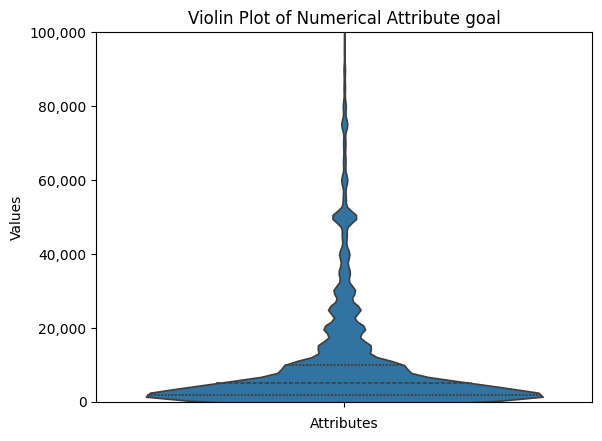

In [114]:
# 1 - looking at general violin plot for goal (with a few scale adjustments)

sns.violinplot(data=kickdata.query('goal < 100000')["goal"], inner='quart')
plt.title("Violin Plot of Numerical Attribute goal")
plt.xlabel("Attributes")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.ylim(0,100000)
plt.show()
plt.close()

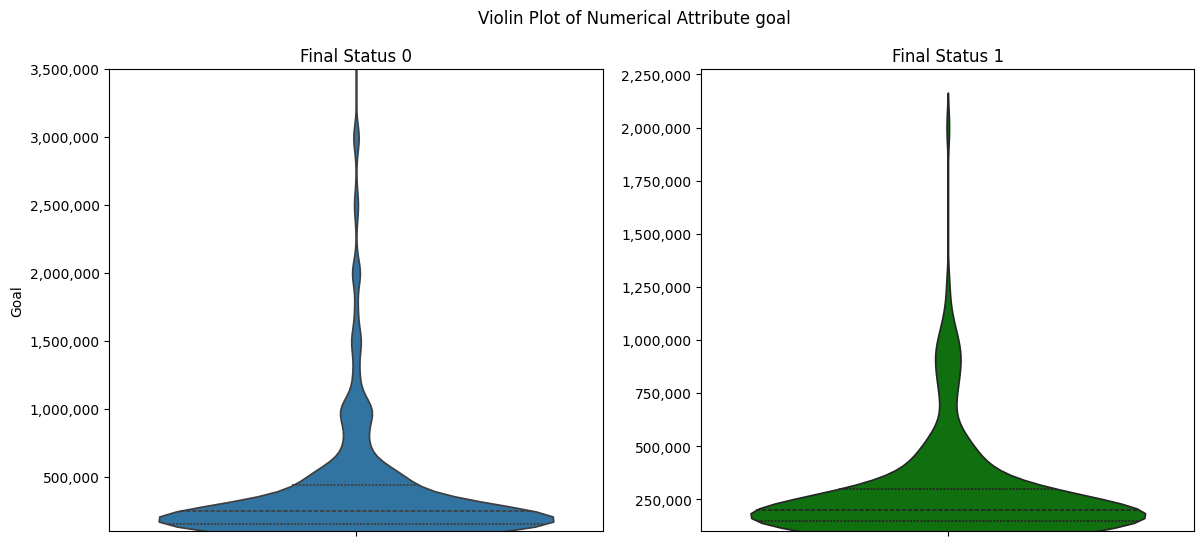

In [115]:
# 2 - analysing potential outliers. Based on the figure with to violinplots,

kickdata.groupby('final_status').size().reset_index(name='count')
kickdata.query('goal > 100000').groupby('final_status').size().reset_index(name='count')

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
sns.violinplot(data=kickdata.query('goal > 100000 & goal < 3500000 & final_status == 0'), y='goal', inner='quart')
plt.title("Final Status 0")
plt.ylabel("Goal")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(100000,3500000)

plt.subplot(1,2,2)
sns.violinplot(data=kickdata.query('goal > 100000 & final_status == 1'), y='goal', inner='quart', color="green")
plt.title("Final Status 1")
plt.ylabel("")  # Remove y-axis label for better alignment
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(100000, )

plt.suptitle("Violin Plot of Numerical Attribute goal")
plt.show()
plt.close()

kickdata = kickdata[kickdata['goal']<3500000]

The distribution of "goal" for successful and failed raisings are roughly the same.
Therefore we could delete extremely large numbers as outliers with minimal affect to future model

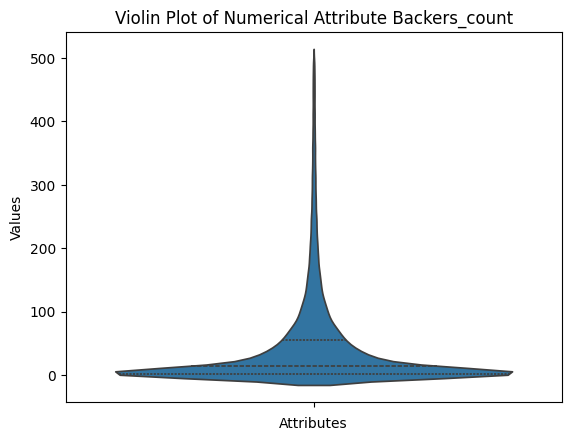

In [116]:
# 3 - looking at general violin plot for backer_count (with a few scale adjustments)
sns.violinplot(data=kickdata.query('backers_count < 500')["backers_count"], inner='quart')
plt.title("Violin Plot of Numerical Attribute Backers_count")
plt.xlabel("Attributes")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.show()
plt.close()

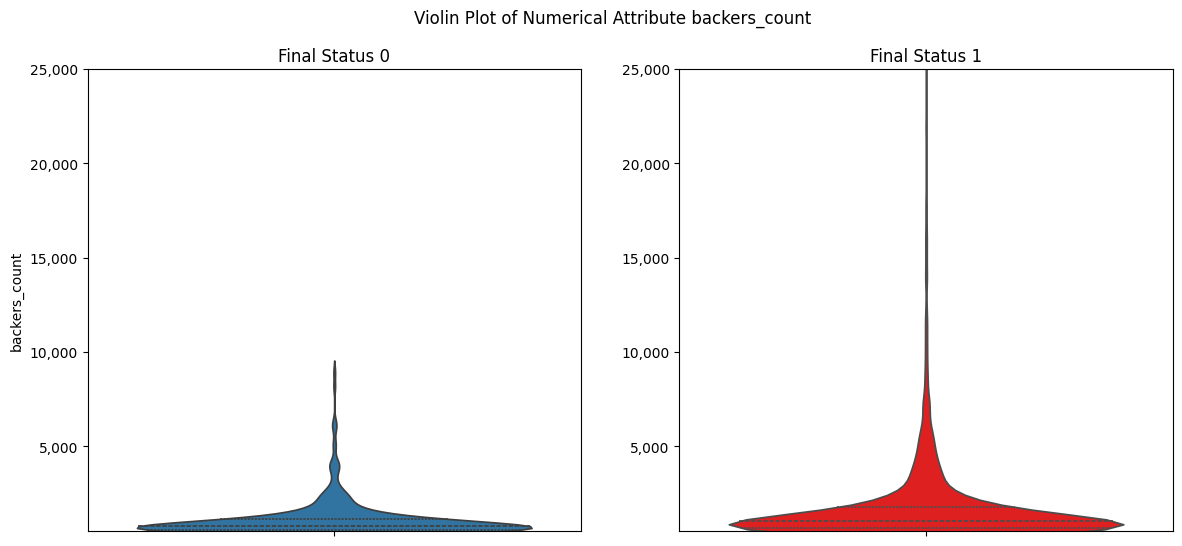

In [117]:
kickdata.query('backers_count >= 500').groupby('final_status').size().reset_index(name='count')

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
sns.violinplot(data=kickdata.query('backers_count >= 500 & final_status == 0'), y='backers_count', inner='quart')
plt.title("Final Status 0")
plt.ylabel("backers_count")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(500, 25000 )

plt.subplot(1,2,2)
sns.violinplot(data=kickdata.query('backers_count >= 500 & backers_count < 25000 & final_status == 1'), y='backers_count', inner='quart', color="red")
plt.title("Final Status 1")
plt.ylabel("")  # Remove y-axis label for better alignment
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(500, 25000 )

plt.suptitle("Violin Plot of Numerical Attribute backers_count")
plt.show()
plt.close()

kickdata = kickdata[kickdata['backers_count']<10000]

There much more outliers for successful projects regarfing total backers, but it has no value, since this attribute cannot be available during prediction of new project success.

## Name, Desc, Keywords

The quality of short Textual attribute is unsatisfactory, especially it may have affect for keywords, that I am going to use for LDA

In [118]:
# DataFrame with lengths of names
def length_count(column: str) -> pd.DataFrame:
    string_col = kickdata[f'{column}'].dropna()
    string_col = string_col.astype(str)
    length_counts = string_col.transform(lambda x: len(x)).value_counts()
    length_counts_df = length_counts.reset_index()
    length_counts_df.columns = ['Length', 'Number']
    length_counts_df = length_counts_df.sort_values(by='Length')
    return length_counts_df

# Looping to see the actual words with short lengths
def loop_to_observe(column: str, data: pd.DataFrame, length_limit: int = 5, step: int = 1):
    # Quality of the shortest names are not satisfactory but no errors were detected
    for i in data['Length'].iloc[0:length_limit]:
        for index, string in list(kickdata[f'{column}'].items())[0::step]:
            length_value = len(string) if pd.notnull(string) else 0
            if length_value == i:
                print(f"Index: {index}, String: {string}, Length: {len(string)}")


#names = length_count('name')
#loop_to_observe('name', names, 3)

#descs = length_count('desc')
#loop_to_observe('desc', descs, 3)

keywords = length_count('keywords')
loop_to_observe('keywords', keywords, 5, 2) # experimented with length limit but takes a lot of space

kickdata = kickdata[kickdata['keywords'].str.len() >= 15]

Index: 51233, String: b, Length: 1
Index: 12197, String: ed, Length: 2
Index: 57304, String: yo, Length: 2
Index: 66669, String: av, Length: 2
Index: 86383, String: ts, Length: 2
Index: 107837, String: on, Length: 2
Index: 32, String: bff, Length: 3
Index: 2594, String: abc, Length: 3
Index: 5457, String: nde, Length: 3
Index: 9297, String: es1, Length: 3
Index: 12231, String: see, Length: 3
Index: 13439, String: lad, Length: 3
Index: 14187, String: din, Length: 3
Index: 14609, String: r-0, Length: 3
Index: 17203, String: ctb, Length: 3
Index: 18181, String: y2k, Length: 3
Index: 20109, String: nyz, Length: 3
Index: 21427, String: exe, Length: 3
Index: 23258, String: sob, Length: 3
Index: 25636, String: bfe, Length: 3
Index: 26579, String: prs, Length: 3
Index: 27204, String: rae, Length: 3
Index: 28841, String: era, Length: 3
Index: 29228, String: ira, Length: 3
Index: 30687, String: mak, Length: 3
Index: 32616, String: awe, Length: 3
Index: 37457, String: sex, Length: 3
Index: 50666,

## Country, Currency

The number of rows for national currencies and the country occurance in data are the same, meaning no semantic errors are there

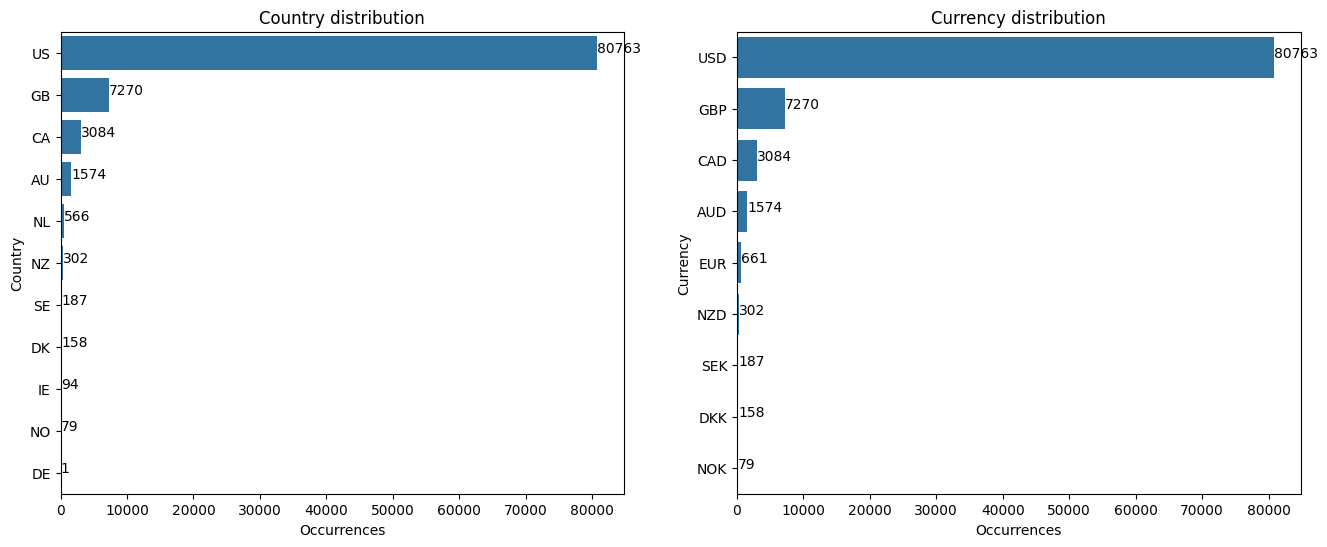

In [119]:
country_counts = kickdata['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Occurrences']
currency_counts = kickdata['currency'].value_counts().reset_index()
currency_counts.columns = ['Currency', 'Occurrences']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
sns.barplot(data=country_counts, x = 'Occurrences', y = 'Country')
plt.title("Country distribution")
plt.xlabel("Occurrences")
plt.ylabel("Country")
for index, row in country_counts.iterrows():
    plt.text(row['Occurrences'], index, row['Occurrences'], color='black', ha="left")

plt.subplot(1,2,2)
sns.barplot(data=currency_counts, x = 'Occurrences', y = 'Currency')
plt.title("Currency distribution")
plt.xlabel("Occurrences")
plt.ylabel("Currency")
for index, row in currency_counts.iterrows():
    plt.text(row['Occurrences'], index, row['Occurrences'], color='black', ha="left")

plt.show()
plt.close()

Looking closer at not freuquent countries to see potential to merge into "Europe group" and "Oceania" (= AUS + NZ).

Turns out that the % of successful projects does not vary much for above mentioned group, so they could be merged (otherwise too minor groups).

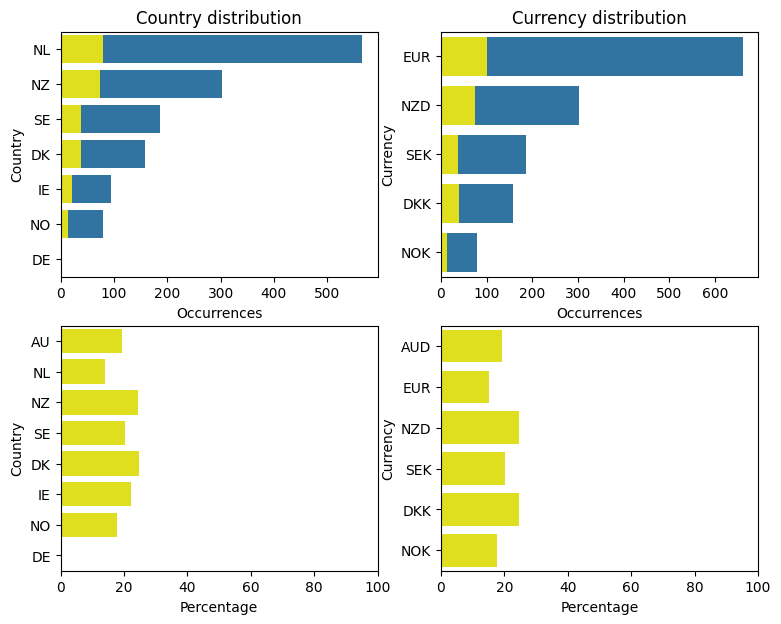

In [120]:
successful_projects_co = kickdata[kickdata['final_status'] == 1].groupby('country').size().reset_index(name='Successful Projects')
country_counts = country_counts.merge(successful_projects_co, left_on='Country', right_on='country', how='left').fillna(0)
country_counts['Success Rate'] = (country_counts['Successful Projects'] / country_counts['Occurrences']) * 100

successful_projects_cu = kickdata[kickdata['final_status'] == 1].groupby('currency').size().reset_index(name='Successful Projects')
currency_counts = currency_counts.merge(successful_projects_cu, left_on='Currency', right_on='currency', how='left').fillna(0)
currency_counts['Success Rate'] = (currency_counts['Successful Projects'] / currency_counts['Occurrences']) * 100

plt.figure(figsize=(9, 7))

# distribution and number of successful projects for unpopular countries and currencies

plt.subplot(2,2,1)
sns.barplot(data=country_counts[~country_counts['Country'].isin(['US', 'GB', 'CA', 'AU'])], x = 'Occurrences', y = 'Country')
sns.barplot(data=country_counts[~country_counts['Country'].isin(['US', 'GB', 'CA', 'AU'])], x = 'Successful Projects', y = 'Country', color = 'yellow')
plt.title("Country distribution")
plt.xlabel("Occurrences")
plt.ylabel("Country")

plt.subplot(2,2,2)
sns.barplot(data=currency_counts[~currency_counts['Currency'].isin(['USD', 'GBP', 'CAD', 'AUD'])], x = 'Occurrences', y = 'Currency')
sns.barplot(data=currency_counts[~currency_counts['Currency'].isin(['USD', 'GBP', 'CAD', 'AUD'])], x = 'Successful Projects', y = 'Currency', color = 'yellow')
plt.title("Currency distribution")
plt.xlabel("Occurrences")
plt.ylabel("Currency")

# Percentage of successful projects for countries and currencies

plt.subplot(2,2,3)
sns.barplot(data=country_counts[~country_counts['Country'].isin(['US', 'GB', 'CA'])], x = 'Success Rate', y = 'Country', color = 'yellow')
plt.xlabel("Percentage")
plt.ylabel("Country")
plt.xlim(0, 100)

plt.subplot(2,2,4)
sns.barplot(data=currency_counts[~currency_counts['Currency'].isin(['USD', 'GBP', 'CAD'])], x = 'Success Rate', y = 'Currency', color = 'yellow')
plt.xlabel("Percentage")
plt.ylabel("Currency")
plt.xlim(0, 100)

plt.show()
plt.close()


# Renaming the values of above-mentioned groups
kickdata['country'] = kickdata['country'].apply(lambda x: 'EUR' if x in ['NL','SE','DK','NO','IE','DE'] else ('OCE' if x in ['AU', 'NZ'] else x))
kickdata['currency'] = kickdata['currency'].apply(lambda x: 'EUR_NEU' if x in ['EUR','SEK','DKK','NOK'] else ('OCE' if x in ['AUD', 'NZD'] else x))

## Dates transformation

In [121]:
# dates transformation
import datetime

for name in ['deadline', 'state_changed_at', 'created_at', 'launched_at']:
    kickdata[name] = kickdata[name].apply(lambda x: datetime.datetime.fromtimestamp(x))

kickdata[['deadline', 'state_changed_at', 'created_at', 'launched_at']].head(3)

kickdata['processing_time'] = kickdata['launched_at'] - kickdata['created_at']
kickdata['possible_time'] = kickdata['deadline'] - kickdata['launched_at']
kickdata['factual_time'] = kickdata['state_changed_at'] - kickdata['launched_at']
kickdata['time_difference'] = kickdata['possible_time'] - kickdata['factual_time']
kickdata.drop(columns=['deadline', 'state_changed_at', 'created_at', 'launched_at'])

kickdata[['processing_time', 'possible_time', 'factual_time', 'time_difference']].head(3)

,processing_time,possible_time,factual_time,time_difference
0,0 days 00:36:56,8 days 11:07:56,8 days 11:08:14,-1 days +23:59:42
1,0 days 04:16:08,16 days 19:43:28,16 days 20:33:46,-1 days +23:09:42
3,0 days 00:48:55,29 days 23:10:10,29 days 23:16:31,-1 days +23:53:39


### Processing time

Visualisation part with histogram and smoothing line allowed to see seasonality in data. Could be related working days and weeks, schedule, automated assistance schedule, etc.

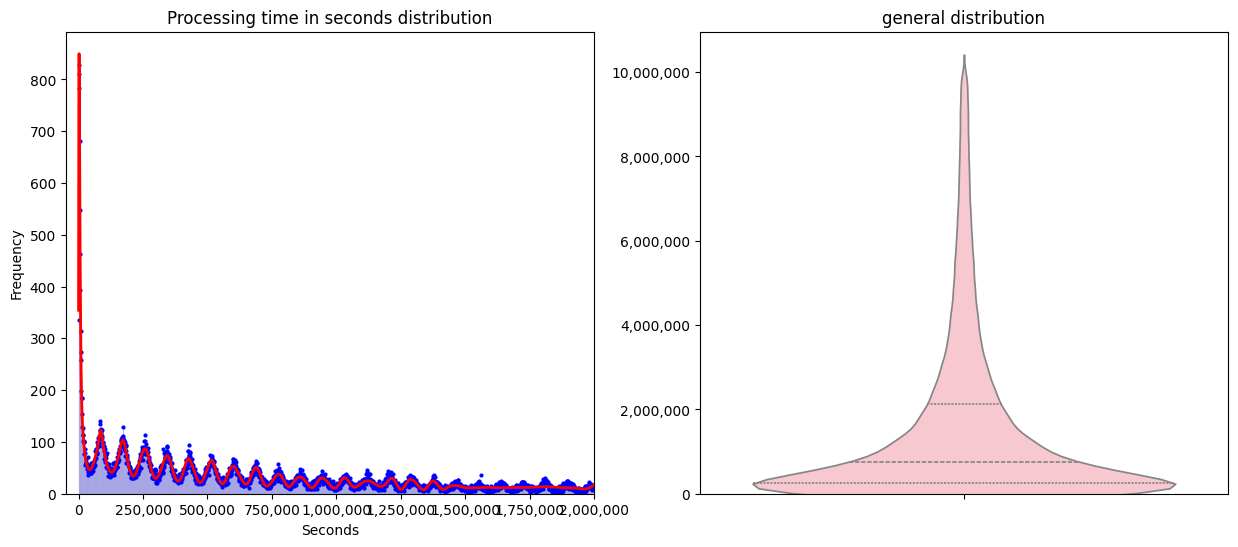

In [122]:
histdata = kickdata["processing_time"].dt.total_seconds()


# Recreating the dataset with which python builds histogram automatically (for scipy smoothing techniqies)
hist_values, hist_edges = np.histogram(histdata[histdata < 2000000], bins=2000)
df = pd.DataFrame({
    'bin': hist_edges[:-1] - 142,
    'count': hist_values})
df['bin'] = df['bin'].astype(int)
#print(df.head())


from scipy.interpolate import splrep, UnivariateSpline
x = df['bin']
y = df['count']
spline = UnivariateSpline(x, y, s=80000)


plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.histplot(data=histdata[histdata < 2000000], bins=2000, color = 'blue', alpha = 0.25)
plt.plot(x, y, 'bo', markersize=2, label='Original data')  # Оригинальные данные
xnew = np.linspace(x.min(), x.max(), 2000)
plt.plot(xnew, spline(xnew), 'r', label='Smoothed spline', linewidth=2)   # Сглаженная кривая
plt.title("Processing time in seconds distribution")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.xlim(-50000,2000000)
plt.ylim(0,)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis

plt.subplot(1,2,2)
sns.violinplot(data=histdata[histdata < 10000000], inner='quart', color="pink")
plt.title("general distribution")
plt.ylabel("")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(0, )

plt.show()
plt.close()


Based on the distribution, the presence of outliers is undoubtful.
Nevertheless, lack of domain knowledge does not allow confident cleaning.
Based on personal assumption I will get rid of processing time values > year (≈1500)

In [123]:


pd.set_option('display.float_format', lambda x: '%.2f' % x) # getting rid of scientific notation
days = histdata.apply(lambda x: x/(60*60*24))
print(days.describe())
days_cleaned = kickdata['processing_time'].apply(lambda x: x.total_seconds()/(60*60*24))

print('\n')
print("different processing time counts")
print('\n')
print(days_cleaned[days_cleaned >= 1000].count())
print(days_cleaned[(days_cleaned >= 365) & (days_cleaned < 1000) ].count())
print(days_cleaned[(days_cleaned >= 31) & (days_cleaned < 365) ].count())
print(days_cleaned[(days_cleaned >= 1) & (days_cleaned < 31)].count())
print(days_cleaned[days_cleaned < 1].count())

kickdata['processing_time'] = kickdata['processing_time'].apply(lambda x: x.total_seconds()/(60*60*24))
kickdata = kickdata[kickdata['processing_time'] < 365]

count   94078.00
mean       38.39
std        88.71
min         0.00
25%         3.07
50%        10.53
75%        32.92
max      1903.80
Name: processing_time, dtype: float64


different processing time counts


62
1420
23069
57825
11702


### Deadlines and factual funding time

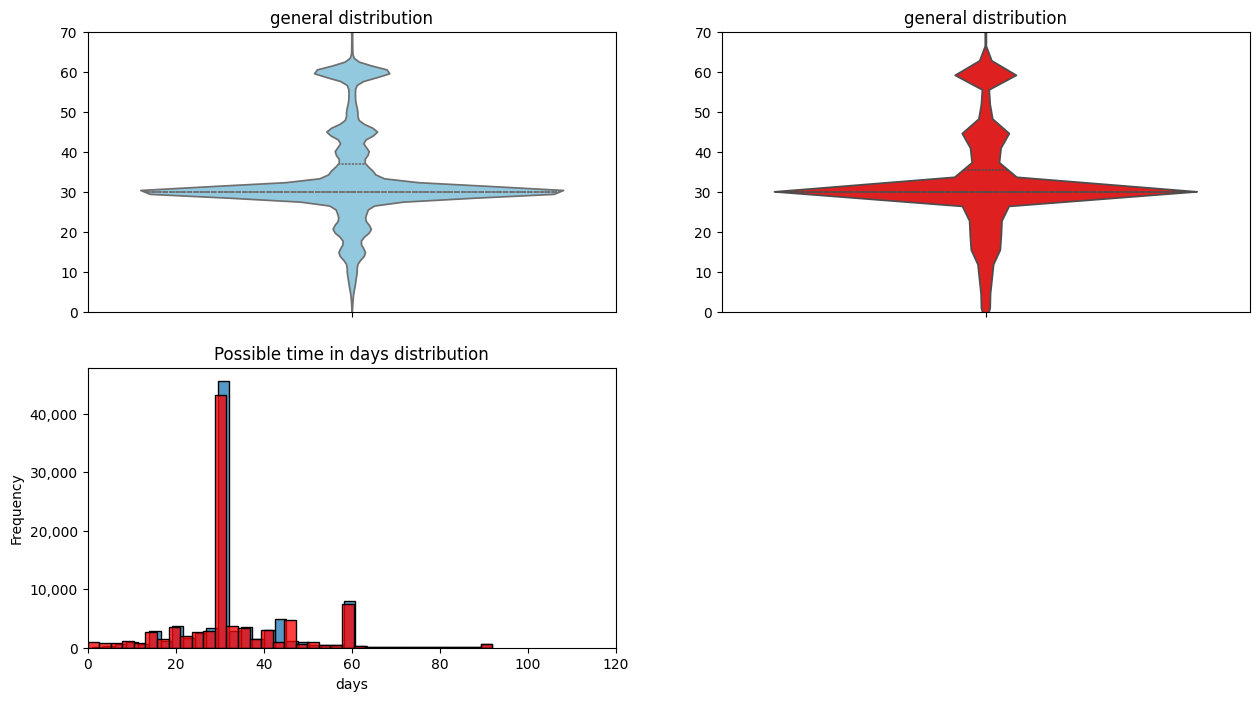

In [124]:
deadlines = kickdata["possible_time"].dt.total_seconds().apply(lambda x: x/(60*60*24))
real_funding_time = kickdata["factual_time"].dt.total_seconds().apply(lambda x: x/(60*60*24))
time_delta = kickdata["time_difference"].dt.total_seconds().apply(lambda x: x/(60*60*24))
time_delta_secs = kickdata["time_difference"].dt.total_seconds()

plt.figure(figsize = (15,8))
plt.subplot(2,2,3)
sns.histplot(data=deadlines[deadlines<120], bins=35)
sns.histplot(data=real_funding_time[real_funding_time<120], bins=35, color = 'red')
plt.title("Possible time in days distribution")
plt.xlabel("days")
plt.ylabel("Frequency")
plt.xlim(0,120)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis

plt.subplot(2,2,1)
sns.violinplot(data=deadlines, inner='quart', color="skyblue")
plt.title("general distribution")
plt.ylabel("")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(0, 70)

plt.subplot(2,2,2)
sns.violinplot(data=real_funding_time, inner='quart', color="red")
plt.title("general distribution")
plt.ylabel("")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.ylim(0, 70)

plt.show()
plt.close()

#print(deadlines[(deadlines >= 80)].count())
#print(real_funding_time[(real_funding_time >= 80)].count())

kickdata['possible_time'] = kickdata['possible_time'].apply(lambda x: x.total_seconds()/(60*60*24))
kickdata = kickdata[kickdata['possible_time'] <= 80]
kickdata['factual_time'] = kickdata['factual_time'].apply(lambda x: x.total_seconds()/(60*60*24))
kickdata = kickdata[kickdata['factual_time'] <= 80]

Observations show very noticable similarities in distribution of deadlines and real_funding_time. Will be checked for correlation to make sure, but using real funding time is cheating anyway since we cannot know for the new project. It won't be part of any model.

### Time difference (between Deadlines and factual funding time)

39225


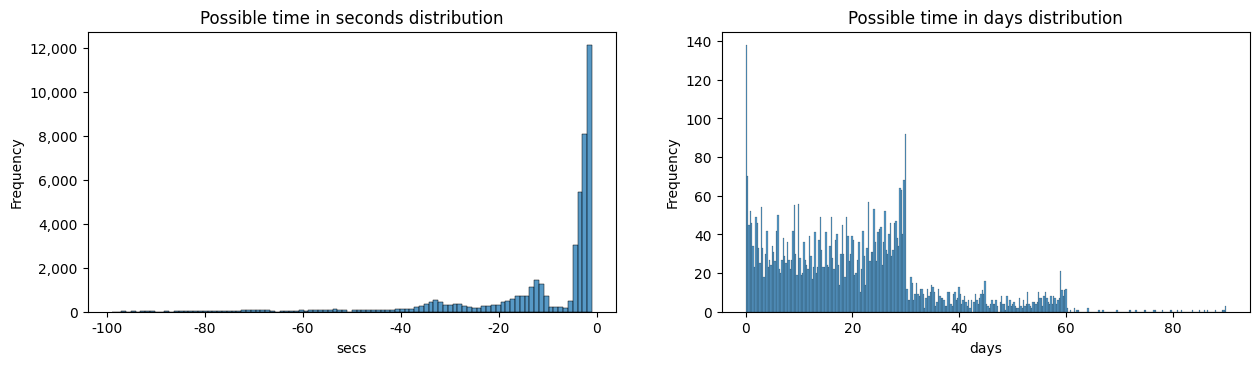

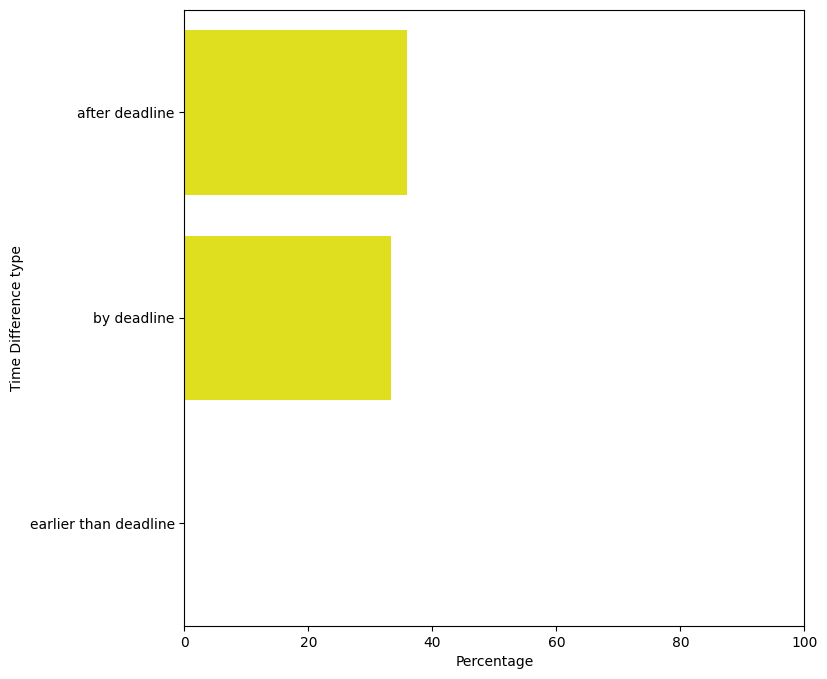

In [125]:

plt.figure(figsize = (15,8))
plt.subplot(2,2,1)
sns.histplot(data=time_delta_secs[(time_delta_secs<0)&(time_delta_secs>-100)], bins=100)
plt.title("Possible time in seconds distribution")
plt.xlabel("secs")
plt.ylabel("Frequency")
#plt.xlim(0,120)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis

print(time_delta[(time_delta == 0)].count())

plt.subplot(2,2,2)
sns.histplot(data=time_delta[time_delta>0], bins=350)
plt.title("Possible time in days distribution")
plt.xlabel("days")
plt.ylabel("Frequency")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis
plt.show()
plt.close()

#print(time_delta[(time_delta <= 0)].count())
kickdata['time_difference'] = kickdata['time_difference'].apply(lambda x: 'after deadline' if x.total_seconds()<0 else ('by deadline' if x.total_seconds() == 0 else 'earlier than deadline'))
#print(kickdata['time_difference'].head())

difference_counts = kickdata['time_difference'].value_counts().reset_index()
difference_counts.columns = ['Time difference', 'Occurrences']
successful_projects_diff = kickdata[kickdata['final_status'] == 1].groupby('time_difference').size().reset_index(name='Successful Projects')
difference_counts = difference_counts.merge(successful_projects_diff, left_on='Time difference', right_on='time_difference', how='left') #.fillna(0)
difference_counts['Success Rate'] = (difference_counts['Successful Projects'] / difference_counts['Occurrences']) * 100

plt.figure(figsize = (8,8))
sns.barplot(data=difference_counts, x = 'Success Rate', y = 'Time difference', color = 'yellow')
plt.xlabel("Percentage")
plt.ylabel("Time Difference type")
plt.xlim(0, 100)
plt.show()
plt.close()
#print(kickdata[(kickdata['final_status'] == 1) & ((kickdata['time_difference'] == 'earlier than deadline'))].value_counts())


the time difference is often slightly negative or equal 0 which must mean that the project status changed shortly after deadline.  This analysis says only projects like this had chance to be successful.

USELESS FOR MODELING anyway as considered as cheating.

## Disable communication

Even though the True value of the attribute is very rare (nearly 300 records),
it is strong indicator that project is less likely to be successful - won't be deleted

   index  disable_communication
0  False                  91296
1   True                    267


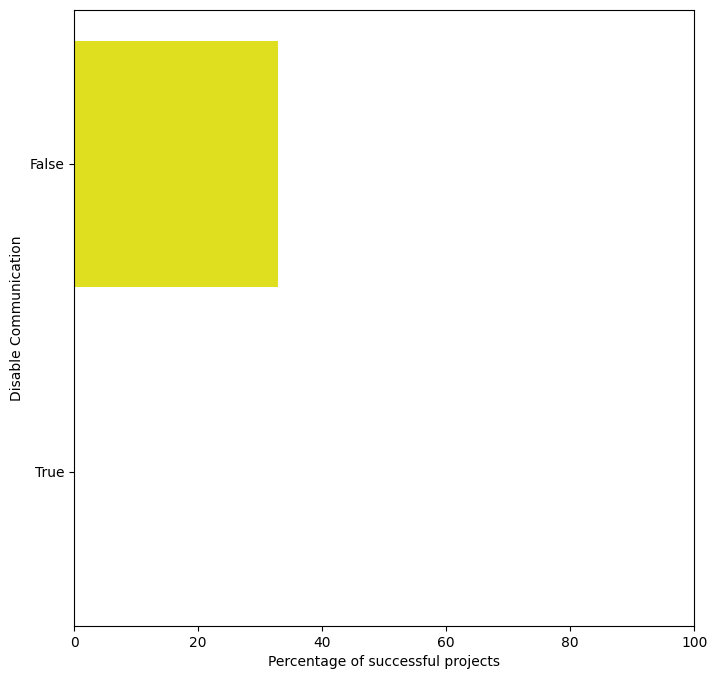

In [126]:
com_counts = kickdata['disable_communication'].value_counts().reset_index()
print(com_counts)

com_counts.columns = ['Disable Communication', 'Occurrences']
successful_projects_diff = kickdata[kickdata['final_status'] == 1].groupby('disable_communication').size().reset_index(name='Successful Projects')
com_counts = com_counts.merge(successful_projects_diff, left_on='Disable Communication', right_on='disable_communication', how='left').fillna(0)
com_counts['Success Rate'] = (com_counts['Successful Projects'] / com_counts['Occurrences']) * 100
com_counts['Disable Communication'] = com_counts['Disable Communication'].astype(str)

plt.figure(figsize = (8,8))
sns.barplot(data=com_counts, x = 'Success Rate', y = 'Disable Communication', color = 'yellow')
plt.xlabel("Percentage of successful projects")
plt.ylabel("Disable Communication")
plt.xlim(0, 100)
plt.show()
plt.close()

## Correlation check

As expected highly correlated actual time and allowed time to raise money, and a bit less correlated final status with final members. In both scenarios there is at least one attribute that cannot be used in modelling due to logical reasons. Spearman correlation used to see beyond linear correlations.


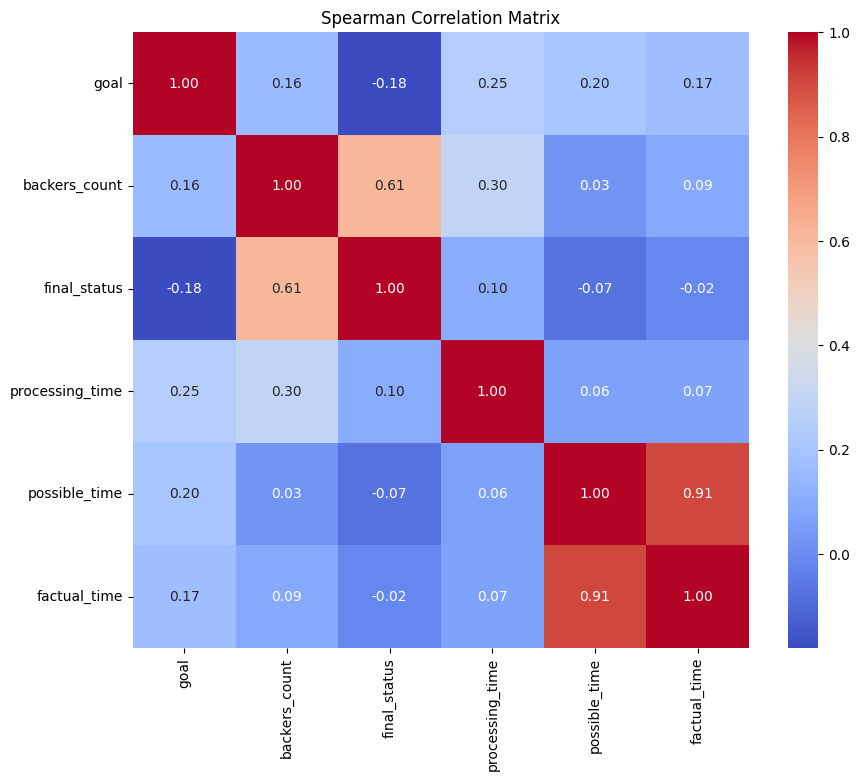

In [127]:
columns = ['goal',
            'backers_count',
            'final_status',
            'processing_time',
            'possible_time',
            'factual_time']
correlation_df = kickdata[columns]

# Normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(correlation_df)
normalized_df = pd.DataFrame(normalized_data, columns=columns)

# Spearman correlation matrix
correlation_matrix = correlation_df.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Spearman Correlation Matrix')
plt.show()
plt.close()

## Topics detection (keywords)

Fopic detection there could be used LDA.

**Input:**  keywords column

**Outputput:**  dataset with the new columns (X = number of topics), representing the weights, showing how certain keywords value relates to each of the topics.

**Custom idea:** using the loop to see how different number of topics chosen affects the accuracy of some ML model and choose best number.

**Steps:**


1.   General data preparation for all future modeling operations (transformation and undersampling) + making smaller the data for LDA
2.   Turning column 'keywords' into required format (dictionary and corpus)
3. Looping from x to y number of topics, to build LDA, then respective dataset and then ML model (simple one, like Decision Tree)
4. Choose the number of topics based on accuracy and do the algorithm with this number on the whole dataset




In [128]:
# General data preparation for all future modeling operations
kickdata = kickdata.drop(['project_id', 'name', 'desc', 'deadline', 'state_changed_at', 'created_at',
                           'launched_at', 'backers_count', 'factual_time', 'time_difference'], axis=1)
kickdata['goal'] = correlation_df['goal']
kickdata['processing_time'] = correlation_df['processing_time']
kickdata['possible_time'] = correlation_df['possible_time']
categorical_columns = ['country', 'currency']
kickdata = pd.get_dummies(kickdata, columns=categorical_columns)
# I should not have done one hot encoding beacuase it was alright for
# decision tree to have categorical attributes!!!


# RANDOM UNDERSAMPLING (ADVANCED METHODS TAKE TOO MUCH TIME)

# Separate majority and minority classes
majority_class = kickdata[kickdata['final_status'] == 0]
minority_class = kickdata[kickdata['final_status'] == 1]
# Randomly select subset of majority class instances
undersampled_majority = majority_class.sample(n=len(minority_class), random_state=228)
# Combine minority class instances with undersampled majority class instances
undersampled_data = pd.concat([undersampled_majority, minority_class])
# Shuffle the combined dataset
kickdata = undersampled_data.sample(frac=1, random_state=228).reset_index(drop=True)

keywords = kickdata['keywords']
kickdata = kickdata.drop(['keywords'], axis=1)



# PREPARATION OF KEYWORDS FOR LDA

# create English stop words list
en_stop = get_stop_words('en')
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
# loop through document list
texts = []
tokenizer = RegexpTokenizer(r'\w+')

for d in keywords:

    # clean and tokenize document string
    raw = d.lower()
    tokens = tokenizer.tokenize(raw)
    #print("tokens:")
    #print(tokens)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    #print("stopped tokens:")
    #print(stopped_tokens)

    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    #print("stemmed tokens:")
    #print(stemmed_tokens)

    # additional tuning based on initial results (deleting most harmful tokens)

    final_tune = [i for i in stemmed_tokens if len(i) > 2]

    # add tokens to list
    texts.append(final_tune)

#for i in texts:
    #print(i)
    #pass

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# preparation for the loop with LDA
dictionary_of_datasets = {}
dictionary_of_accuracies = {}

kickdata2 = kickdata.sample(n=15000, random_state=42)
kickdata2 = kickdata2.reset_index(drop=True)

tree = DecisionTreeClassifier(random_state=228)



for i in list(range(5,30)):

    break # to avoid time consuming code execution



    # Apply LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, passes=5)

    # Create columns for each topic in the DataFrame
    keywords_topics = [ldamodel.get_document_topics(d) for d in corpus]
    dataset_i = kickdata2.copy()

    for topic in range(ldamodel.num_topics):
        dataset_i[f'Topic_{topic}_Weight'] = 0.0

    for index, d_topics in enumerate(keywords_topics):
        for topic, weight in d_topics:
            try:
                dataset_i.at[index, f"Topic_{topic}_Weight"] = weight
            except:
                dataset_i.at[index, f"Topic_{topic}_Weight"] = 0.0

    dictionary_of_datasets[f'dataset_{i}'] = dataset_i

    # building and evaluating the Random Forest model on current dataset
    X,y = dictionary_of_datasets[f'dataset_{i}'].drop('final_status', axis=1), dictionary_of_datasets[f'dataset_{i}']['final_status']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    tree.fit(X_train, y_train)
    accuracy_i = accuracy_score(y_test, tree.predict(X_test))
    dictionary_of_accuracies[i] = accuracy_i
    print(f"{i} iteration is completed")



# Key with maximal accuracy (hiden since loop not activated)

#max_accuracy_key = max(dictionary_of_accuracies, key=dictionary_of_accuracies.get)
#print("The best accuracy when the number of topics is:", max_accuracy_key)
#print(dictionary_of_accuracies)

 No essential difference in number of topics, from the first side pretty  useless attributes, not increasing model performance.

 Decided based on decision tree accuracies (since it is fast)
 Absolutely randomly chose 10 topics (for fun's sake).

Further development of the project would lead me to creation of bool variables regarding IT, Fun, Art and other groups while iteratively using ChatGPT

In [129]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=5)

# Create columns for each topic in the DataFrame
keywords_topics = [ldamodel.get_document_topics(d) for d in corpus]

for topic in range(ldamodel.num_topics):
        kickdata[f'Topic_{topic}_Weight'] = 0.0

for index, d_topics in enumerate(keywords_topics):
    for topic, weight in d_topics:
        try:
            kickdata.at[index, f"Topic_{topic}_Weight"] = weight
        except:
            kickdata.at[index, f"Topic_{topic}_Weight"] = 0.0

# Select boolean columns
bool_columns = kickdata.select_dtypes(include=bool).columns
# Convert boolean attributes to integer
kickdata[bool_columns] = kickdata[bool_columns].astype(int)

## Clustering

I wanted to quickly check using one of the easiest methods if data tend to form clusters naturally, however it was no good, despite obvious number of clusters based on elbow method

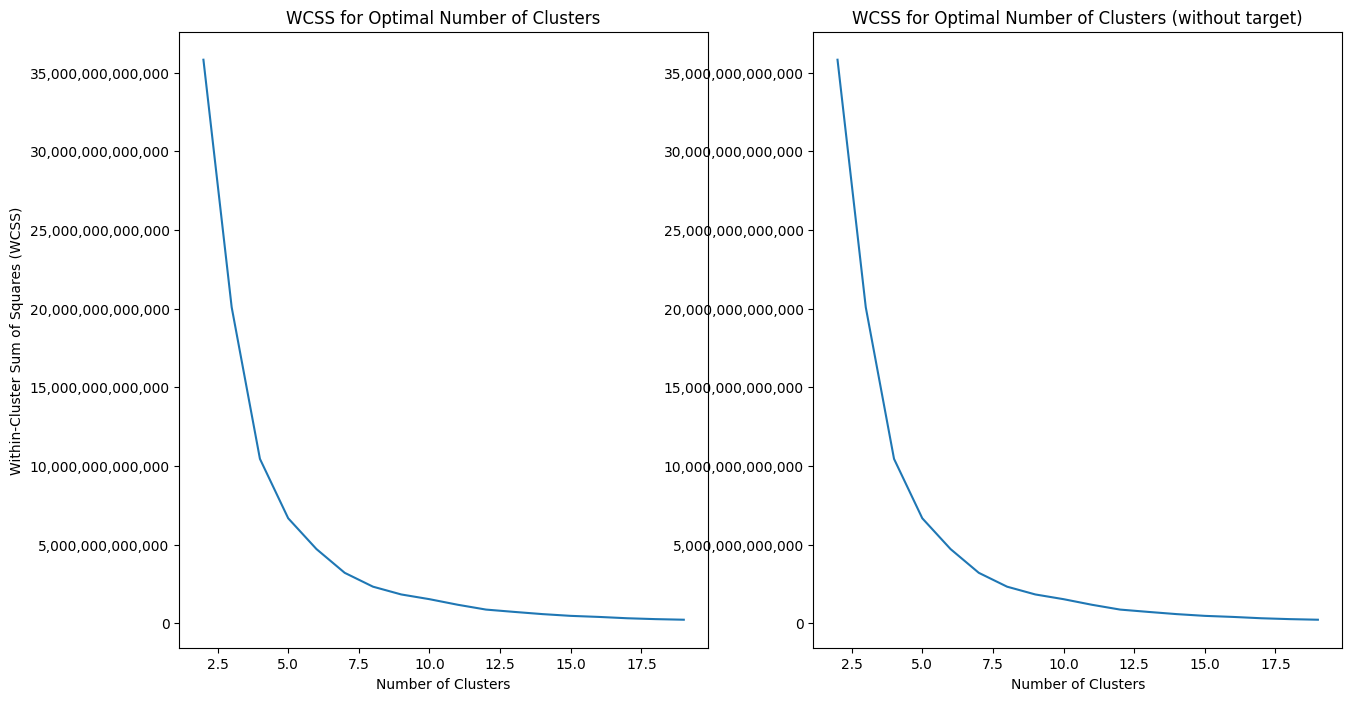

In [130]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

wcss1 = []

for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(kickdata2)  # X is your feature matrix
    wcss1.append(kmeans.inertia_)


wcss2 = []

kickdata_wo_target = kickdata2.drop(columns=['final_status'], axis=1)
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(kickdata_wo_target)  # X is your feature matrix
    wcss2.append(kmeans.inertia_)


# different values but very close
# print(wcss1, wcss2)

# Plot the WCSS scores
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(2, 20), wcss1)
plt.title('WCSS for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis

plt.subplot(1, 2, 2)
plt.plot(range(2, 20), wcss2)
plt.title('WCSS for Optimal Number of Clusters (without target)')
plt.xlabel('Number of Clusters')
plt.ylabel('')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.show()
plt.close()

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(kickdata_wo_target)
kickdata_wo_target['cluster'] = cluster_labels
kickdata_wo_target.groupby('cluster').size() # too bad - imbalanced

cluster
0    13897
1        8
2       22
3      916
4      157
dtype: int64

## Modeling and evaluatyion
### Just simple fitting and evaluation

accuracy: 0.5897145898476482, kappa: 0.17945200589016652
accuracy: 0.5451400439092542, kappa: 0.09027857786373383
accuracy: 0.610205575144701, kappa: 0.22039859349105195
accuracy: 0.6008249617457255, kappa: 0.201642598267469


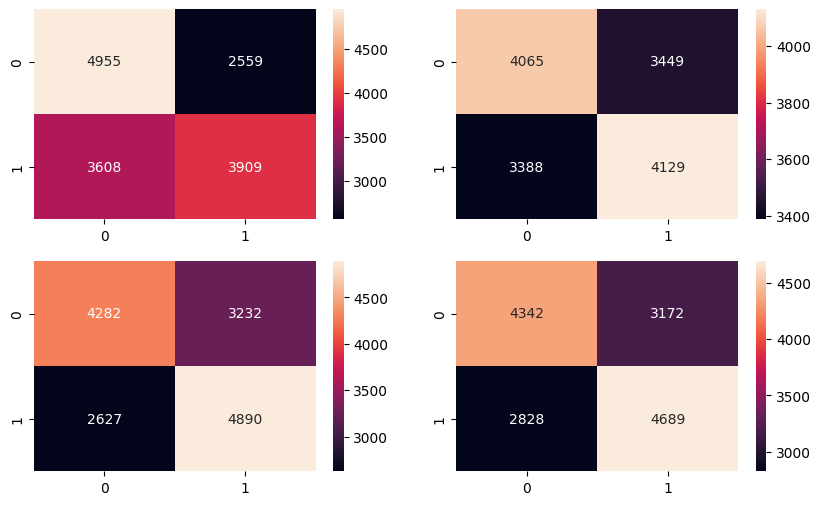

In [131]:
X,y = kickdata.drop('final_status', axis=1), kickdata['final_status']
log_reg = LogisticRegression(random_state=228)
tree = DecisionTreeClassifier(random_state=228)
xgb = xgb.XGBClassifier()
forest = RandomForestClassifier(random_state=228, n_estimators=100)

def modeling(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy_1 = accuracy_score(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    return print(f'accuracy: {accuracy_1}, kappa: {kappa}')

def cm(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    return cm

modeling(log_reg)
modeling(tree)
modeling(xgb)
modeling(forest)


# Plotting the confusion matrix with class names
plt.figure(figsize=(10, 6))
plt.subplot(2,2,1)
sns.heatmap(cm(log_reg), annot=True, fmt = 'g', xticklabels=[0,1], yticklabels=[0,1])
plt.subplot(2,2,2)
sns.heatmap(cm(tree), annot=True, fmt = 'g', xticklabels=[0,1], yticklabels=[0,1])
plt.subplot(2,2,3)
sns.heatmap(cm(xgb), annot=True, fmt = 'g', xticklabels=[0,1], yticklabels=[0,1])
plt.subplot(2,2,4)
sns.heatmap(cm(forest), annot=True, fmt = 'g', xticklabels=[0,1], yticklabels=[0,1])
plt.show()

## Cross validation

In [132]:
def my_cv(model):
    kfold = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score = accuracy_score(y_test, model.predict(X_test))
        scores.append(score)
    return print(f'accuracy scores{scores}, mean accuracy: {np.mean(scores)}')

my_cv(forest)

accuracy scores[0.6044074844074844, 0.6014137214137214, 0.6061538461538462, 0.6074012474012473, 0.6107784431137725], mean accuracy: 0.6060309484980143


## Hyperparameter tuning

On my machine it was dreadfully slow to check even a small range with changed parameters, so I did it for presentation's sake. Yes I know this technique and I like the idea. Want to learn more on optimisation to avoid using GridSearch.

Best Parameters: {'n_estimators': 250}
Test Accuracy: 0.6093247588424437


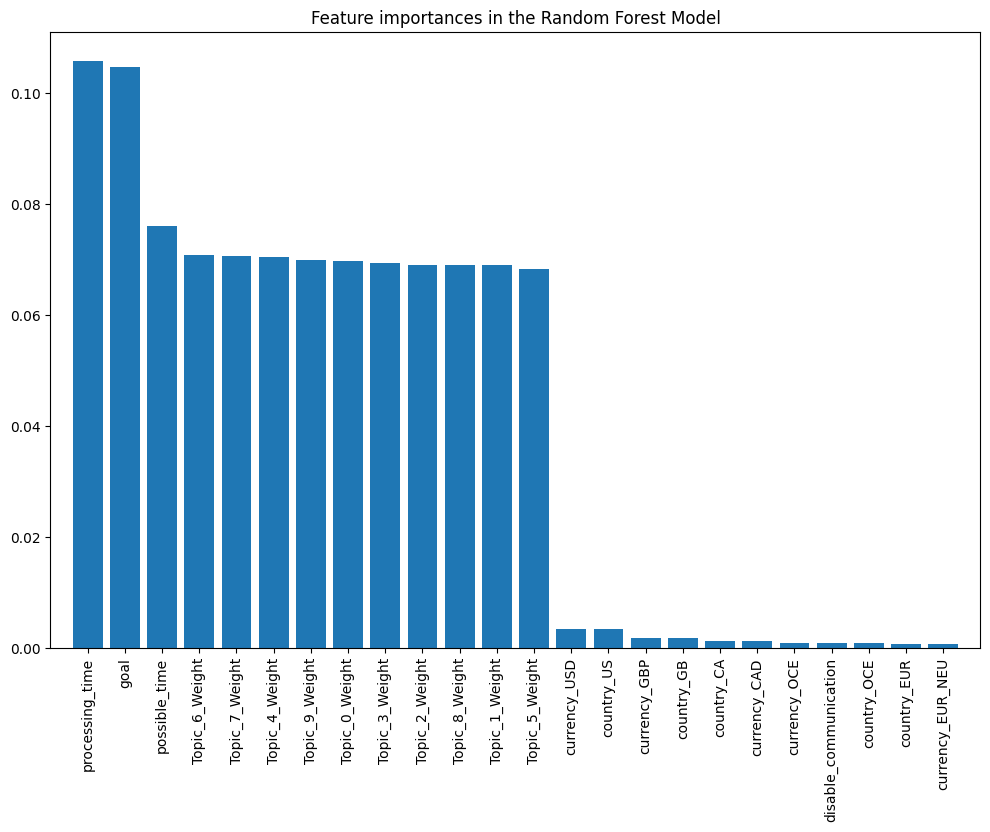

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for the grid search
param_grid = {'n_estimators': [50, 150, 250]}  # Example values for n_estimators

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(random_state=0)

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=3)

# Fit the grid search to the data (this will try all possible combinations of parameters)
grid_search.fit(X_train, y_train)

# Get the best parameters found by the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator (model) found by the grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


# Extracting feature importances
importances = best_rf_model.feature_importances_

# Sorting the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearranging your features so they match the sorted feature importances
features = X.columns

# Creating the plot
plt.figure(figsize=(12, 8))
plt.title("Feature importances in the Random Forest Model (infornation gain)")
plt.bar(range(X.shape[1]), importances[indices], align="center")

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

# Show the plot
plt.show()
plt.close()